In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#探索的データ分析のためのライブラリインポート
import numpy as np
import pandas as pd
!pip install -U kaleido
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image, display
#!pip install Japanize-matplotlib
import japanize_matplotlib


In [3]:
#データの読み込み
train_df=pd.read_csv("../input/titanic/train.csv")
test_df=pd.read_csv("../input/titanic/test.csv")


In [4]:
# 不要な警告を抑える
import warnings
warnings.filterwarnings("ignore" ,message=".*invalid value encountered in.*")

In [5]:
#見やすくinfoを比べる
from io import StringIO
from IPython.display import display , HTML
buffer1=StringIO()
buffer2=StringIO()
train_df.info(buf=buffer1)
test_df.info(buf=buffer2)
info1=buffer1.getvalue()
info2=buffer2.getvalue()
html = f"""
<div style="display: flex; gap: 10px;">
    <div>
        <div style="font-weight: bold; margin-bottom: 5px;">Train</div>
        <pre style="border: 1px solid #ccc; padding: 10px;">{info1}</pre>
    </div>
    <div>
        <div style="font-weight: bold; margin-bottom: 5px;">Test</div>
        <pre style="border: 1px solid #ccc; padding: 10px;">{info2}</pre>
    </div>
</div>
"""
display(HTML(html))


In [6]:
#passengerIDはindexと実質同じであることの確認
assert((train_df["PassengerId"]==train_df.index+1).all())
assert((test_df["PassengerId"]==test_df.index+1+len(train_df)).all())



In [7]:
#性質ごとに特徴量を分ける
target="Survived" #目的変数
cont_num_att=["Age" ,"Fare"] #連続値
disc_num_att=["SibSp" , "Parch"] #離散値
cat_att=["Pclass" , "Embarked" , "Sex"]#カテゴリ変数



# 探索的データ分析
##### Survived
* 訓練データの61%は死亡している
* 訓練データに対して、予測精度61%は最低でも必要
##### Age Fare
* ほとんどの乗客は20~40歳
* ほとんどの乗客の運賃は非常に安い
##### SibSp Parch
* ほとんどの乗客は家族と一緒ではない
##### Sex Pclass Embarked
* 64%男性 7割S 55%3等


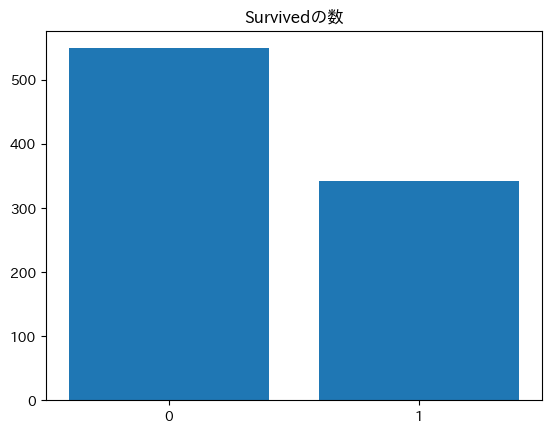

[0.61616162 0.38383838]


In [10]:
#survived
cat,counts=np.unique(train_df["Survived"] ,return_counts=True)
plt.bar(x=cat.astype(str) , height=counts)
plt.title("Survivedの数")
plt.show()

perc = counts/len(train_df)
print(perc)

cat,counts=np.unique(train_df[target] ,return_counts=True)
perc=(counts/len(train_df)*100).round(1)
import plotly.graph_objects as go



fig = make_subplots(rows=1, cols=1, subplot_titles=[target])

cat, counts = np.unique(train_df[target], return_counts=True)
perc = (counts / len(train_df[target]) * 100).round(1)
fig.add_trace(
    go.Bar(
        x=cat.astype(str),
        y=counts,
        width=0.5,
        text=np.char.add(perc.astype(str), "%"),
        textfont_size=11,
        hovertext=counts,
        hoverinfo="text",
        textposition="outside",
        marker_color="royalblue",
    ),
    row=1,
    col=1,
)
fig.update_yaxes(range=[0,counts.max()*1.15],row=1 , col=1)
fig.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



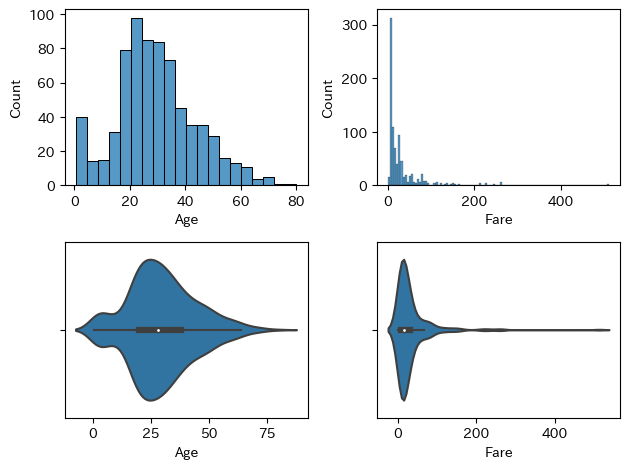

In [16]:
#Age Fare

fig,axes=plt.subplots(2,2)
sns.histplot(train_df,x="Age",ax=axes[0,0])
sns.violinplot(train_df , x="Age"  ,ax=axes[1,0])
sns.histplot(train_df , x="Fare" ,ax=axes[0,1])
sns.violinplot(train_df , x="Fare" , ax=axes[1,1])
plt.tight_layout()
plt.show()

n_cols=2
n_groups=(len(cont_num_att)+n_cols-1)//n_cols

height_ratios=[]
for g in range(n_groups):
    height_ratios.extend([2.75 , 1])
    if g != n_groups-1:
        height_ratiow.append(0.9)

n_rows=len(height_ratios)
fig , axes=plt.subplots(n_rows,n_cols , figsize=(9.5,3*n_groups)　
                       ,gridspec_kw={'heigt_ratios' :height_ratios})
axes=axes.reshape(n_rows,n_cols)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Parch', ylabel='Count'>

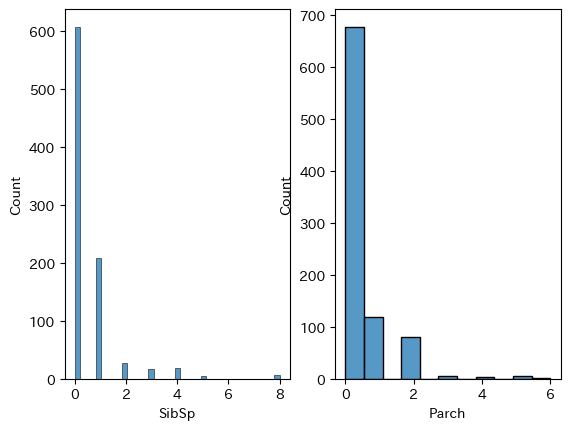

In [15]:
fig,axes=plt.subplots(1,2)
sns.histplot(train_df["SibSp"],ax=axes[0] )
sns.histplot(train_df["Parch"] , ax=axes[1])

In [ ]:
fix ,axes=plt.subplots(2,2)
sns.countplot(data=train_df,x="Sex" ,ax=axes[0,0])
sns.countplot(data=train_df ,x="Pclass" ,ax=axes[0,1])
sns.countplot(data=train_df , x="Embarked" ,ax=axes[1,1])
plt.tight_layout()
plt.show()
for col in ["Sex" ,"Pclass" ,"Embarked"]:
    cat,counts=np.unique(train_df[col].dropna() , return_counts=True)
    print(col,counts/len(train_df))

In [ ]:
train_df[cat_att].agg(lambda x: (x.unique())).T

# Nameから情報を得る
- 全員苗字がわかっている
- 同じ名前の人はいない
- セカンドネームを持っている人がいる

In [ ]:
assert train_df["Name"].str.match(r"\S.*,").all()
assert test_df["Name"].str.match(r"\S.*,").all()
print(len(train_df),len(np.unique(train_df["Name"])))
print(len(test_df) , len(np.unique(test_df["Name"])))

In [ ]:
train_df["Surname"]=train_df["Name"].str.split(",").str[0]
test_df["Surname"]=test_df["Name"].str.split(",").str[0]

In [ ]:
# Surnames with non-alphabetic characters 
train_df.loc[lambda x: x['Surname'].str.contains(r"[^a-zA-Z '\s]"), ['Surname']]
#train_df.loc[lambda x: x["Surname"].str.contains(r"[^a-z A-Z ' \s]") ,["Surname"]]